In [1]:
#-------Import Dependencies-------#
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from time import time
from PIL import ImageDraw
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
from scipy.ndimage import imread

from keras import backend as K
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetMobile
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

Using TensorFlow backend.


In [2]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [3]:
train_dir = '../input/seg_train/seg_train/'
test_dir = '../input/seg_test/seg_test/'

In [4]:
augs = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,  
    zoom_range=0.2,        
    horizontal_flip=True,
    validation_split=0.3)  

train_gen = augs.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size=8,
    class_mode = 'categorical'
)

test_gen = augs.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=8,
    class_mode='categorical'
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [5]:
def ConvBlock(model, layers, filters,name):
    for i in range(layers):
        model.add(SeparableConv2D(filters, (3, 3), activation='relu',name=name))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
def FCN():
    model = Sequential()
    model.add(Lambda(lambda x: x, input_shape=(150, 150, 3)))
    ConvBlock(model, 1, 16,'block_1')
    ConvBlock(model, 1, 32,'block_2')
    ConvBlock(model, 1, 64,'block_3')
    ConvBlock(model, 1, 128,'block_4')
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6,activation='sigmoid'))
    return model

model = FCN()
model.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 150, 150, 3)       0         
_________________________________________________________________
block_1 (SeparableConv2D)    (None, 148, 148, 16)      91        
_________________________________________________________________
batch_normalization_1 (Batch (None, 148, 148, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
block_2 (SeparableConv2D)    (None, 72, 72, 32)        688       
_________________________________________________________________
batch_normalization_2 (Batch (None, 72, 72, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
__________

In [6]:
#-------Callbacks-------------#
best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

#lrsched = LearningRateScheduler(step_decay,verbose=1)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=40,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [7]:
opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=2e-4)

model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)
    
history = model.fit_generator(
    train_gen, 
    steps_per_epoch  = 500, 
    validation_data  = test_gen,
    validation_steps = 500,
    epochs = 20, 
    verbose = 1,
    callbacks=callbacks
)

Epoch 1/20
500/500 [==============================] - 61s 122ms/step - loss: 0.4940 - acc: 0.8169 - val_loss: 0.4856 - val_acc: 0.8229

Epoch 00001: val_loss improved from inf to 0.48561, saving model to ./base.model
Epoch 2/20
500/500 [==============================] - 58s 117ms/step - loss: 0.3296 - acc: 0.8627 - val_loss: 0.3329 - val_acc: 0.8608

Epoch 00002: val_loss improved from 0.48561 to 0.33285, saving model to ./base.model
Epoch 3/20
500/500 [==============================] - 58s 116ms/step - loss: 0.2979 - acc: 0.8765 - val_loss: 0.2942 - val_acc: 0.8742

Epoch 00003: val_loss improved from 0.33285 to 0.29425, saving model to ./base.model
Epoch 4/20
500/500 [==============================] - 58s 116ms/step - loss: 0.2818 - acc: 0.8798 - val_loss: 0.2462 - val_acc: 0.8934

Epoch 00004: val_loss improved from 0.29425 to 0.24620, saving model to ./base.model
Epoch 5/20
500/500 [==============================] - 57s 114ms/step - loss: 0.2586 - acc: 0.8893 - val_loss: 0.2640 - v

Model Test Loss: 0.18407066136101882
Model Test Accuracy: 0.9269999968210856
Weights Saved


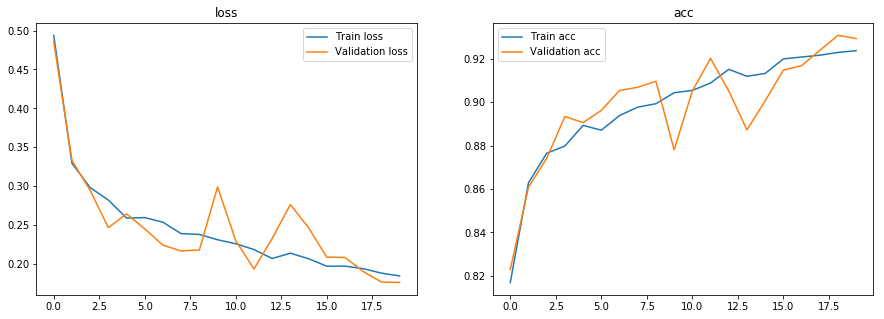

In [8]:
show_final_history(history)
model.load_weights(best_model_weights)
model_score = model.evaluate_generator(test_gen)
print("Model Test Loss:",model_score[0])
print("Model Test Accuracy:",model_score[1])

model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
    
model.save("model.h5")
print("Weights Saved")

In [9]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
LOG_DIR = './logs' # Here you have to put your log directory
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 8080 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 8080 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


--2019-02-18 00:20:00--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.92.108.98, 34.196.237.103, 52.204.188.97, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.92.108.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  9.67MB/s    in 0.5s    

2019-02-18 00:20:01 (9.67 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://83ee6539.ngrok.io
